# Data Mining Techniques | Project 2
> Spring Semester 2022-2023

> Stylianos Oikonomou | 1115201500243

<img src='https://i.pinimg.com/originals/e4/26/70/e426702edf874b181aced1e2fa5c6cde.gif' style='width:50%;'>

In [ ]:
import re
import math
import numpy as np
import pandas as pd
from pandas import DataFrame
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
import pickle
import torch

# Stopwords
import nltk.corpus
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

pd.set_option('display.max_columns', None)
# pd.set_option('max_colwidth', 1000)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Import Data Set

In [ ]:
source = "https://zenodo.org/records/4265096/files/books_1.Best_Books_Ever.csv?download=1"

df = pd.read_csv(source, sep = ',')

Inspect the data

In [ ]:
df.head()

,bookId,title,series,author,rating,description,language,isbn,genres,characters,bookFormat,edition,pages,publisher,publishDate,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,coverImg,bbeScore,bbeVotes,price
0,2767052-the-hunger-games,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,English,9780439023481,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...","['Katniss Everdeen', 'Peeta Mellark', 'Cato (H...",Hardcover,First Edition,374,Scholastic Press,09/14/08,NaN,['Locus Award Nominee for Best Young Adult Boo...,6376780,"['3444695', '1921313', '745221', '171994', '93...",96.0,"['District 12, Panem', 'Capitol, Panem', 'Pane...",https://i.gr-assets.com/images/S/compressed.ph...,2993816,30516,5.09
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,English,9780439358071,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...","['Sirius Black', 'Draco Malfoy', 'Ron Weasley'...",Paperback,US Edition,870,Scholastic Inc.,09/28/04,06/21/03,['Bram Stoker Award for Works for Young Reader...,2507623,"['1593642', '637516', '222366', '39573', '14526']",98.0,['Hogwarts School of Witchcraft and Wizardry (...,https://i.gr-assets.com/images/S/compressed.ph...,2632233,26923,7.38
2,2657.To_Kill_a_Mockingbird,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,The unforgettable novel of a childhood in a sl...,English,9999999999999,"['Classics', 'Fiction', 'Historical Fiction', ...","['Scout Finch', 'Atticus Finch', 'Jem Finch', ...",Paperback,NaN,324,Harper Perennial Modern Classics,05/23/06,07/11/60,"['Pulitzer Prize for Fiction (1961)', 'Audie A...",4501075,"['2363896', '1333153', '573280', '149952', '80...",95.0,"['Maycomb, Alabama (United States)']",https://i.gr-assets.com/images/S/compressed.ph...,2269402,23328,NaN
3,1885.Pride_and_Prejudice,Pride and Prejudice,NaN,"Jane Austen, Anna Quindlen (Introduction)",4.26,Alternate cover edition of ISBN 9780679783268S...,English,9999999999999,"['Classics', 'Fiction', 'Romance', 'Historical...","['Mr. Bennet', 'Mrs. Bennet', 'Jane Bennet', '...",Paperback,"Modern Library Classics, USA / CAN",279,Modern Library,10/10/00,01/28/13,[],2998241,"['1617567', '816659', '373311', '113934', '767...",94.0,"['United Kingdom', 'Derbyshire, England (Unite...",https://i.gr-assets.com/images/S/compressed.ph...,1983116,20452,NaN
4,41865.Twilight,Twilight,The Twilight Saga #1,Stephenie Meyer,3.60,About three things I was absolutely positive.\...,English,9780316015844,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...","['Edward Cullen', 'Jacob Black', 'Laurent', 'R...",Paperback,NaN,501,"Little, Brown and Company",09/06/06,10/05/05,"['Georgia Peach Book Award (2007)', 'Buxtehude...",4964519,"['1751460', '1113682', '1008686', '542017', '5...",78.0,"['Forks, Washington (United States)', 'Phoenix...",https://i.gr-assets.com/images/S/compressed.ph...,1459448,14874,2.1


In [ ]:
df.isnull().sum()

bookId                  0
title                   0
series              29008
author                  0
rating                  0
description          1338
language             3806
isbn                    0
genres                  0
characters              0
bookFormat           1473
edition             47523
pages                2347
publisher            3696
publishDate           880
firstPublishDate    21326
awards                  0
numRatings              0
ratingsByStars          0
likedPercent          622
setting                 0
coverImg              605
bbeScore                0
bbeVotes                0
price               14365
dtype: int64

Rows that contain NaN values will be dropped when not needed

# Preprocessing

## ratingsByStars

In [ ]:
# remove NaN values
df = df[df['ratingsByStars'].notna()]
df = df[df['ratingsByStars'] != '[]']

# create the separate rating columns
if 'ratingStar1' not in df.columns:
  df.insert(df.columns.get_loc('ratingsByStars') + 1, 'ratingStar1', '')
if 'ratingStar2' not in df.columns:
  df.insert(df.columns.get_loc('ratingsByStars') + 1, 'ratingStar2', '')
if 'ratingStar3' not in df.columns:
  df.insert(df.columns.get_loc('ratingsByStars') + 1, 'ratingStar3', '')
if 'ratingStar4' not in df.columns:
  df.insert(df.columns.get_loc('ratingsByStars') + 1, 'ratingStar4', '')
if 'ratingStar5' not in df.columns:
  df.insert(df.columns.get_loc('ratingsByStars') + 1, 'ratingStar5', '')

for index, row in df.iterrows():
  # separate the ratings
  row_string = re.sub(r"[\[\]\s']", '', row['ratingsByStars'])
  tok = row_string.split(",")
  # insert them at their own cells
  df.at[index, 'ratingStar5'] = int(tok[0])
  df.at[index, 'ratingStar4'] = int(tok[1])
  df.at[index, 'ratingStar3'] = int(tok[2])
  df.at[index, 'ratingStar2'] = int(tok[3])
  df.at[index, 'ratingStar1'] = int(tok[4])

df[['ratingsByStars', 'ratingStar5', 'ratingStar4', 'ratingStar3', 'ratingStar2', 'ratingStar1']].head()

,ratingsByStars,ratingStar5,ratingStar4,ratingStar3,ratingStar2,ratingStar1
0,"['3444695', '1921313', '745221', '171994', '93...",3444695,1921313,745221,171994,93557
1,"['1593642', '637516', '222366', '39573', '14526']",1593642,637516,222366,39573,14526
2,"['2363896', '1333153', '573280', '149952', '80...",2363896,1333153,573280,149952,80794
3,"['1617567', '816659', '373311', '113934', '767...",1617567,816659,373311,113934,76770
4,"['1751460', '1113682', '1008686', '542017', '5...",1751460,1113682,1008686,542017,548674


## genreSingle

In [ ]:
# remove NaN values
df = df[df['genres'].notna()]

if 'genreSingle' not in df.columns:
  df.insert(df.columns.get_loc('genres') + 1, 'genreSingle', '')

for index, row in df.iterrows():
  # separate the ratings
  row_string = re.sub(r"[\[\]\s']", '', row['genres'])
  tok = row_string.split(",")
  # insert them at their own cells
  df.at[index, 'genreSingle'] = tok[0]

df[['genres', 'genreSingle']].head()

,genres,genreSingle
0,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...",YoungAdult
1,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...",Fantasy
2,"['Classics', 'Fiction', 'Historical Fiction', ...",Classics
3,"['Classics', 'Fiction', 'Romance', 'Historical...",Classics
4,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...",YoungAdult


## publishYear

In [ ]:
# remove NaN values
df = df[df['publishDate'].notna()]

if 'publishYear' not in df.columns:
  df.insert(df.columns.get_loc('publishDate') + 1, 'publishYear', '')

date_formats = ['%m/%d/%y', '%B %dth %Y', '%B %dst %Y', '%B %dnd %Y', '%B %drd %Y']

for index, row in df.iterrows():
  for date_format in date_formats:
    try:
      date_object = datetime.strptime(row['publishDate'], date_format)
      df.at[index, 'publishYear'] = date_object.strftime('%Y')
      break
    except ValueError:
        continue

df[['publishDate', 'publishYear']].head()

,publishDate,publishYear
0,09/14/08,2008
1,09/28/04,2004
2,05/23/06,2006
3,10/10/00,2000
4,09/06/06,2006


## description

In [ ]:
# remove NaN values
df = df[df['bookId'].notna()]
df = df[df['description'].notna()]
df.shape[0]

49283

Remove rows with non English descriptions

In [ ]:
!pip install pycld2

import importlib
if not importlib.util.find_spec('pycld2'):
  !pip install pycld2

import pycld2 as cld2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
rows_to_drop = []
for index, row in df.iterrows():
    # if the language of the description is English then store the row
    try:
      result = cld2.detect(row['description'])
    except:
      pass
    if result[2][0][0] != 'ENGLISH':
        rows_to_drop.append(index)

df = df.drop(rows_to_drop)
df.shape[0]

43963

Clean Descriptions

In [ ]:
def clean_description(text):
    # remove non-letter characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # convert to lowercase
    text = text.lower()
    # remove multiple whitespaces
    text = re.sub(r'\s+', ' ', text)
    # remove stop-words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['description'] = df['description'].apply(clean_description)

# Data Analysis

### 1. Histogram of ratings

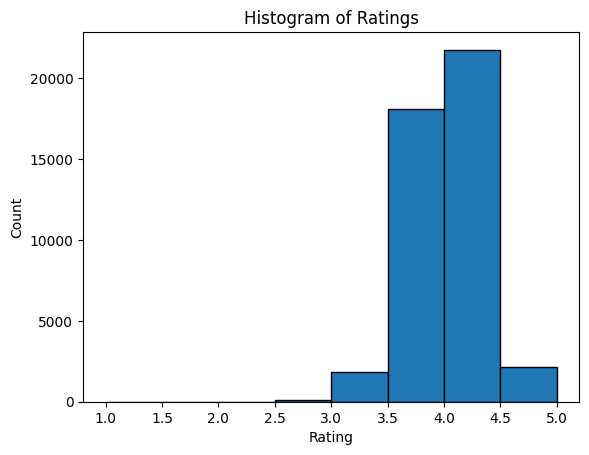

In [ ]:
# copy the DataFrame
temp_df =  df.copy()
# remove NaN values
temp_df = temp_df[temp_df['rating'].notna()]

# bins = range(math.floor(df['rating'].min()), math.ceil(df['rating'].max()) + 1)
# bins = range(1, 6)
bins = np.arange(1, 5.5, 0.5)

plt.hist(temp_df['rating'], bins=bins, edgecolor='black')

plt.title('Histogram of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(bins, labels=bins)

plt.show()

### 2. 10 books with the most pages

In [ ]:
top_n = 10

# copy the DataFrame
temp_df = df.copy()
# remove NaN values
temp_df = temp_df[temp_df['pages'].notna()]

# convert the values from string to numerical
try:
  temp_df['pages'] = temp_df['pages'].str.replace(r'\D+', '', regex=True).astype(int)
except:
  pass
# sort the pages column
sorted_data = temp_df.sort_values('pages', ascending=False)
# select the top n rows by page count
top_rows = sorted_data.head(top_n)

# print('Pages \t Title')
# print('--------------------------------------------------------------')
# for idx in top_rows.index:
#   print(temp_df.loc[idx]['pages'], '\t', temp_df.loc[idx]['title'])

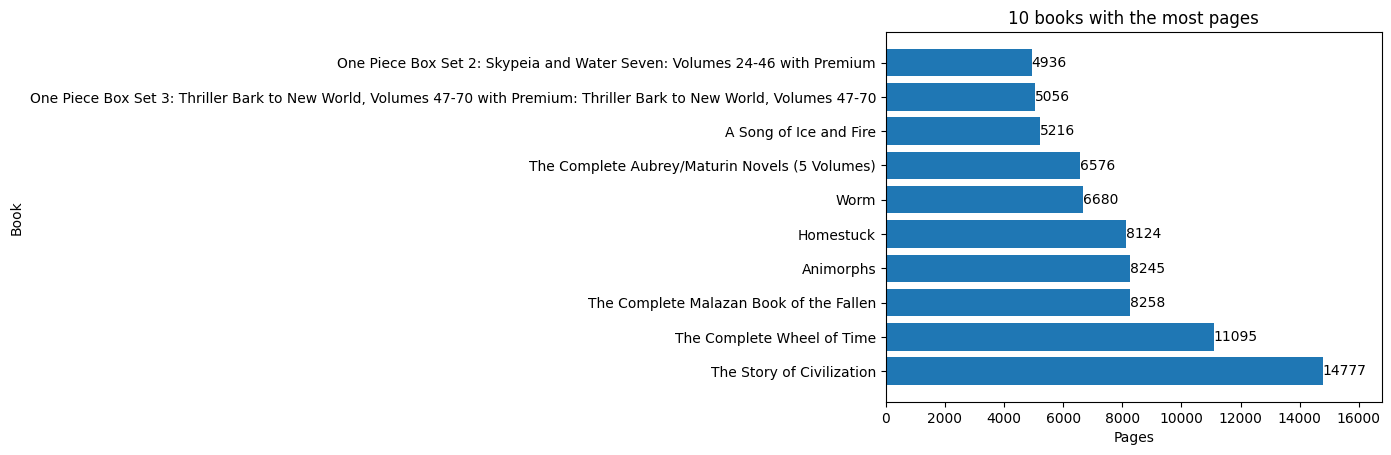

In [ ]:
plt.barh(top_rows['title'].tolist(), top_rows['pages'].tolist())

plt.title('10 books with the most pages')
plt.xlabel('Pages')
plt.ylabel('Book')

for i, v in enumerate(top_rows['pages'].tolist()):
    plt.text(v, i, str(v), ha = 'left', va='center')
plt.xlim(0, max(top_rows['pages'].tolist()) + 2000)

plt.show()

### 3. 10 books with the most 5-star Ratings

In [ ]:
top_n = 10

# copy the DataFrame
temp_df = df.copy()
# remove NaN values
temp_df = temp_df[temp_df['ratingStar5'].notna()]

# select the books with ratingStar5 above 10000
temp_df = temp_df[temp_df['ratingStar5'] > 10000]
# sort the ratingStar5 column
sorted_data = temp_df.sort_values('ratingStar5', ascending=False)
# select the top n rows by ratingStar5 count
top_rows = sorted_data.head(top_n)

# print('ratingStar5 \t Title')
# print('--------------------------------------------------------------')
# for idx in top_rows.index:
#   print(df.loc[idx]['ratingStar5'], '\t', df.loc[idx]['title'])

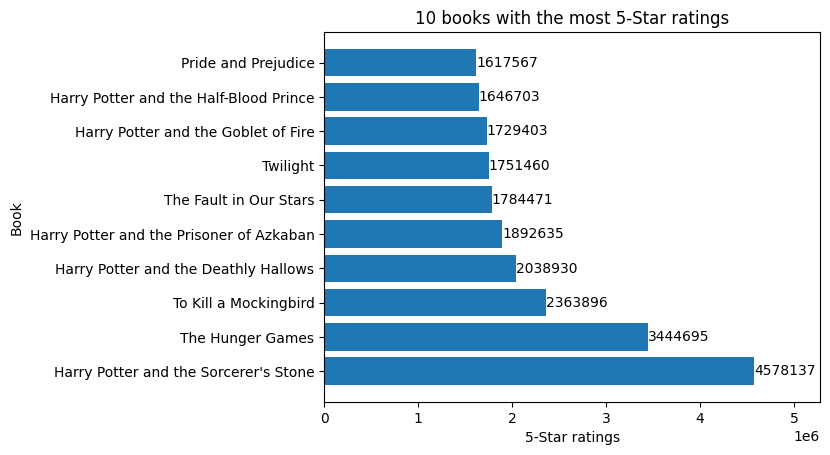

In [ ]:
plt.barh(top_rows['title'].tolist(), top_rows['ratingStar5'].tolist())

plt.title('10 books with the most 5-Star ratings')
plt.xlabel('5-Star ratings')
plt.ylabel('Book')

for i, v in enumerate(top_rows['ratingStar5'].tolist()):
    plt.text(v, i, str(v), ha = 'left', va='center')
plt.xlim(0, max(top_rows['ratingStar5'].tolist()) + 700000)

plt.show()

### 4. 10 most common words in Book Titles

In [ ]:
top_n = 10

# copy the DataFrame
temp_df = df.copy()
# remove NaN values
temp_df = temp_df[temp_df['title'].notna()]

# remove any non word characters
temp_df['title'] = temp_df['title'].str.replace(r'[\W\d_]+', ' ', regex=True)
# join all titles to a single string
all_titles = ' '.join(temp_df['title'].tolist())
# add the title words to a list
title_words = all_titles.lower().split()
# remove all stop-words
filtered_words = [word for word in title_words if word not in stop_words]
# count the unique words
word_counts = Counter(filtered_words)
# select the top n word counts
top_n_words = word_counts.most_common(top_n)

# print('Count \t Title Word')
# print('--------------------------------------------------------------')
# for (word, count) in top_n_words:
#   print(count, '\t', word)

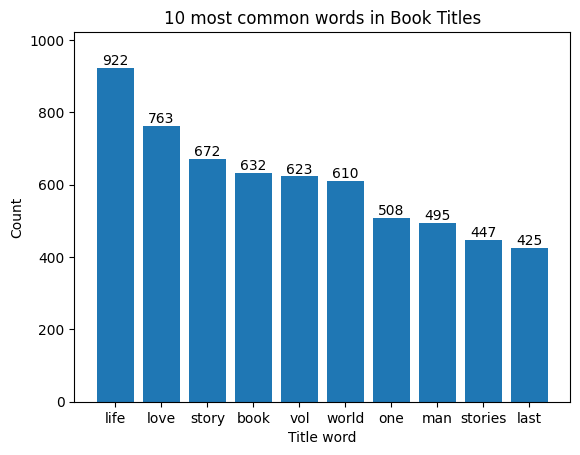

In [ ]:
word_list = [word for (word, count) in top_n_words]
count_list = [count for (word, count) in top_n_words]

plt.bar(word_list, count_list)

plt.title('10 most common words in Book Titles')
plt.xlabel('Title word')
plt.ylabel('Count')

for i, count in enumerate(count_list):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.ylim(0, max(count_list) + 100)

plt.show()

In [ ]:
del all_titles, title_words, filtered_words

### 5. 10 Authors with the most Books

In [ ]:
top_n = 10

# copy the DataFrame
temp_df = df.copy()
# remove NaN values
temp_df = temp_df[temp_df['author'].notna()]

top_n_authors = temp_df['author'].value_counts().nlargest(top_n)

# print('Books \t Author')
# print('--------------------------------------------------------------')
# for author, books in top_n_authors.items():
#   print(books, '\t', author)

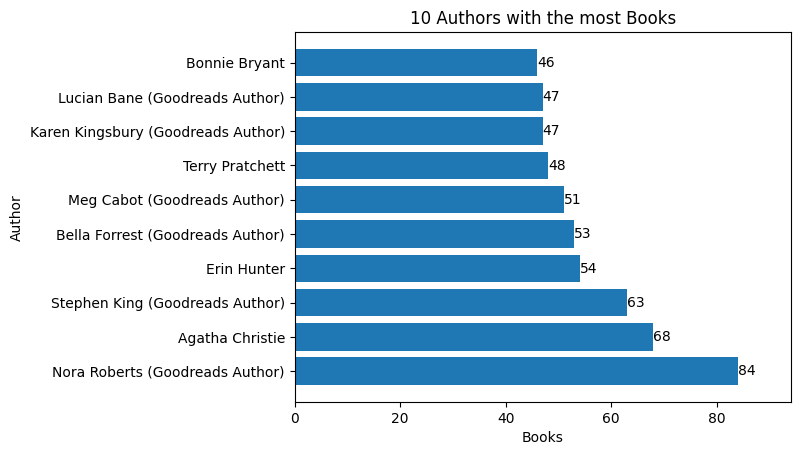

In [ ]:
author_list = [author for author, books in top_n_authors.items()]
book_list = [books for author, books in top_n_authors.items()]

plt.barh(author_list, book_list)

plt.title('10 Authors with the most Books')
plt.xlabel('Books')
plt.ylabel('Author')

for i, v in enumerate(book_list):
    plt.text(v, i, str(v), ha = 'left', va='center')
plt.xlim(0, max(book_list) + 10)

plt.show()

In [ ]:
del temp_df

# Recommendation system implementation

## TF-IDF Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 2000
sample_size = 25000

df_sample = df.sample(sample_size)
df_sample = df_sample.reset_index(drop=True)

In [ ]:
unigram_vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=max_features, stop_words='english')
unigram_matrix = unigram_vectorizer.fit_transform(df_sample['description'])

In [ ]:
bigram_vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=max_features, stop_words='english')
bigram_matrix = bigram_vectorizer.fit_transform(df_sample['description'])

## Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

unigram_similarity = cosine_similarity(unigram_matrix)
bigram_similarity = cosine_similarity(bigram_matrix)

## Recommendation Function

To conserve space and excecution time the similarity checks will be performed at every call of the recommendation function and won't be stored in a book dictionary.

In [ ]:
def recommend_gram(book_Id, N, gram):
  book_idx = df_sample.loc[df_sample['bookId'] == book_Id].index[0]
  # create a dictionary to store the similar books
  similar_books = {}
  # for every book calculate the similarity
  if gram == 'unigram':
    similarity_type = unigram_similarity
  else:
    similarity_type = bigram_similarity
  for i, similarity_scores in enumerate(similarity_type):
    if i != book_idx:
        similar_books[i] = similarity_scores[book_idx]
  # sort the books by order of similarity
  sorted_similar_books = sorted(similar_books.items(), key=lambda x: x[1], reverse=True)
  # select the top N similar books
  top_similar_books = sorted_similar_books[:N]

  if gram == 'unigram':
    print(" Unigram \n" +
          "=========")
  else:
    print(" Bigram \n" +
          "========")

  print(  f"Recommending {N} books similar to: {df_sample.iloc[book_idx]['title']} \n" +
          "-------------------------------------------------------------------------------------------------- \n")

  for (idx, score) in top_similar_books:

    print(  f"Recommended: {df_sample.iloc[idx]['title']} \n" +
            f"BookID     : {df_sample.iloc[idx]['bookId']} \n" +
            f"Description: {df_sample.iloc[idx]['description']} \n" +
            f"(score:{score}) \n\n")

In [ ]:
def recommend(book_Id, N):
  # check if the book exists in the sample
  if book_Id not in df_sample['bookId'].values:
    print("Error: The book does not exist in the book sample")
    return

  recommend_gram(book_Id, N, 'unigram')
  recommend_gram(book_Id, N, 'bigram')

Recommend Book

In [ ]:
# # Random bookId
# random_book_id = df_sample.sample()['bookId'].values[0]
random_book_id = '2767052-the-hunger-games'
N = 5

recommend(random_book_id, N)

 Unigram 
Recommending 5 books similar to: The Hunger Games 
-------------------------------------------------------------------------------------------------- 

Recommended: Guide to The Hunger Games 
BookID     : 12414235-guide-to-the-hunger-games 
Description: guide hunger games offers new way interact enthralling world young adult publishing phenomenon suzanne collins hunger games trilogy companion provides deeper insight inspiration behind thrilling adventure series well contemporary themes root profiling main characters providing coverage th th hunger games tournaments long standing fans refresh knowledge new ones explore dystopian setting panem illuminating detail complete beautiful illustrations fascinating elements collins creation covered muttations amazing designs katniss stylist cinna guide hunger games comes perfect time coinciding highly anticipated film adaptation first book whether avid reader seeking introduction film guide hunger games provides perfect way engage exci

In [ ]:
del unigram_matrix, unigram_similarity, unigram_vectorizer, bigram_matrix, bigram_similarity, bigram_vectorizer, df_sample

# Classification

Select the rows that belong to the top 10 common genre list

In [ ]:
# find the top 10 common genres
top_10_common = df['genreSingle'].value_counts().head(10).index
# create a new DataFrame
df_temp = df[df['genreSingle'].isin(top_10_common)]
df_temp.shape[0]

26966

Drop the unneeded columns

In [ ]:
df_temp = df[['bookId', 'description', 'genreSingle']]
df_temp.head()

,bookId,description,genreSingle
0,2767052-the-hunger-games,winning means fame fortune losing means certai...,YoungAdult
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,door end silent corridor haunting harry pottte...,Fantasy
2,2657.To_Kill_a_Mockingbird,unforgettable novel childhood sleepy southern ...,Classics
3,1885.Pride_and_Prejudice,alternate cover edition isbn since immediate s...,Classics
4,41865.Twilight,three things absolutely positive first edward ...,YoungAdult


## Create Features with Word2Vec

In [ ]:
def create_features(path, feature_count):

  from gensim.models import Word2Vec

  descriptions = [description.split() for description in df_temp['description']]
  # train the Word2Vec model
  w2v = Word2Vec(descriptions, vector_size=feature_count, min_count=1, window=5)

  # create a Word2Vec dictionary
  w2v_dict = {}
  for word in w2v.wv.key_to_index:
      w2v_dict[word] = w2v.wv[word]

  def descriptionEmbending(description):
    word_list = description.split()
    # number of words in the description
    description_words = len(word_list)
    # collect the word embendings
    emb = [[0] * feature_count]
    for word in word_list:
      # if the word exists in the w2v model the word embending will be returned, else error
      if word in w2v_dict:
        emb.append(w2v_dict[word])
      else:
        description_words -= 1
    # calcualte the sum
    emb_sum = [sum(x) for x in zip(*emb)]
    # if there is at least one valid word return the mean of the embendings, return a 0 initialized list otherwise
    if description_words != 0:
      emb_mean = [x/description_words for x in emb_sum]
      return emb_mean
    else:
      return [0] * feature_count

  features = df_temp[['description']].applymap(descriptionEmbending)

  # store the features
  with open(path, 'wb') as file:
      pickle.dump(features, file)

  return features

In [ ]:
def load_features(path):
  with open(path, 'rb') as file:
    features = pickle.load(file)
    return features

In [ ]:
features_path = '/content/drive/MyDrive/ΤΕΔε/Project_2/features.pkl'

# features = create_features(features_path, 200)
features = load_features(features_path)

## Train Classifiers

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

Encode the genreSingle values

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

encoded_genreSingle = encoder.fit_transform(df_temp['genreSingle'])

In [ ]:
X = torch.tensor(features['description'], dtype=torch.float)
Y = torch.tensor(encoded_genreSingle, dtype=torch.float)

print(f"x shape: {X.shape}")
print(f"y shape: {Y.shape}")

x shape: torch.Size([43963, 200])
y shape: torch.Size([43963])


In [ ]:
NB_scores  = {}
SVC_scores = {}
RF_scores  = {}

### Naive Bayes

In [ ]:
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

naive_bayes = GaussianNB()

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
for train_idx, test_idx in kfold.split(X):

    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    # fit the classifier
    naive_bayes.fit(X_train, Y_train)
    # make predictions
    Y_pred = naive_bayes.predict(X_test)
    # calculate scores
    precision_scores.append(precision_score(Y_test, Y_pred, average='weighted', zero_division=1))
    recall_scores.append(recall_score(Y_test, Y_pred, average='weighted', zero_division=1))
    f1_scores.append(f1_score(Y_test, Y_pred, average='weighted', zero_division=1))
    accuracy_scores.append(accuracy_score(Y_test, Y_pred))

# calculate the average scores
precision_mean = sum(precision_scores) / len(precision_scores)
recall_mean = sum(recall_scores) / len(recall_scores)
f1_mean = sum(f1_scores) / len(f1_scores)
accuracy_mean = sum(accuracy_scores) / len(accuracy_scores)

NB_scores['precision'] = precision_mean
NB_scores['recall'] = recall_mean
NB_scores['f1'] = f1_mean
NB_scores['accuracy'] = accuracy_mean

del naive_bayes

### SVM

Use GirdSearch to find the most optimal parameters for the SVC model

In [ ]:
# precision_scores = []
# recall_scores = []
# f1_scores = []
# accuracy_scores = []

# svm = SVC()

# param_grid = {'kernel': ['rbf', 'linear'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}

# kfold = KFold(n_splits=2, shuffle=True, random_state=42)

# grid_search = GridSearchCV(svm, param_grid, cv=kfold)

# for train_idx, test_idx in kfold.split(X):

#     X_train, X_test = X[train_idx], X[test_idx]
#     Y_train, Y_test = Y[train_idx], Y[test_idx]
#     # fit the classifier
#     grid_search.fit(X_train, Y_train)
#     # make predictions
#     Y_pred = grid_search.predict(X_test)

# del grid_search, svm

In [ ]:
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print(best_params)
# print(best_score)

Best SVC parameters : {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

svm = SVC(C=10, gamma='scale', kernel='rbf')

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
for train_idx, test_idx in kfold.split(X):

    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    # fit the classifier
    svm.fit(X_train, Y_train)
    # make predictions
    Y_pred = svm.predict(X_test)
    # calculate scores
    precision_scores.append(precision_score(Y_test, Y_pred, average='weighted', zero_division=1))
    recall_scores.append(recall_score(Y_test, Y_pred, average='weighted', zero_division=1))
    f1_scores.append(f1_score(Y_test, Y_pred, average='weighted', zero_division=1))
    accuracy_scores.append(accuracy_score(Y_test, Y_pred))

# calculate the average scores
precision_mean = sum(precision_scores) / len(precision_scores)
recall_mean = sum(recall_scores) / len(recall_scores)
f1_mean = sum(f1_scores) / len(f1_scores)
accuracy_mean = sum(accuracy_scores) / len(accuracy_scores)

SVC_scores['precision'] = precision_mean
SVC_scores['recall'] = recall_mean
SVC_scores['f1'] = f1_mean
SVC_scores['accuracy'] = accuracy_mean

del svm

### Random Forest

In [ ]:
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

rf = RandomForestClassifier()

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
for train_idx, test_idx in kfold.split(X):

    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    # fit the classifier
    rf.fit(X_train, Y_train)
    # make predictions
    Y_pred = rf.predict(X_test)
    # calculate scores
    precision_scores.append(precision_score(Y_test, Y_pred, average='weighted', zero_division=1))
    recall_scores.append(recall_score(Y_test, Y_pred, average='weighted', zero_division=1))
    f1_scores.append(f1_score(Y_test, Y_pred, average='weighted', zero_division=1))
    accuracy_scores.append(accuracy_score(Y_test, Y_pred))

# calculate the average scores
precision_mean = sum(precision_scores) / len(precision_scores)
recall_mean = sum(recall_scores) / len(recall_scores)
f1_mean = sum(f1_scores) / len(f1_scores)
accuracy_mean = sum(accuracy_scores) / len(accuracy_scores)

RF_scores['precision'] = precision_mean
RF_scores['recall'] = recall_mean
RF_scores['f1'] = f1_mean
RF_scores['accuracy'] = accuracy_mean

del rf

## Results

In [ ]:
results = pd.DataFrame(columns=['precision', 'recall', 'f1', 'accuracy'])

results.loc['Naive_Bayes'] = {'precision': NB_scores['precision'],
                              'recall': NB_scores['recall'],
                              'f1': NB_scores['f1'],
                              'accuracy': NB_scores['accuracy']}

results.loc['SVM'] = {'precision': SVC_scores['precision'],
                              'recall': SVC_scores['recall'],
                              'f1': SVC_scores['f1'],
                              'accuracy': SVC_scores['accuracy']}

results.loc['Random_Forest'] = {'precision': RF_scores['precision'],
                              'recall': RF_scores['recall'],
                              'f1': RF_scores['f1'],
                              'accuracy': RF_scores['accuracy']}

In [ ]:
results

,precision,recall,f1,accuracy
Naive_Bayes,0.312370,0.134636,0.142314,0.134636
SVM,0.467291,0.438869,0.398061,0.438869
Random_Forest,0.481599,0.372609,0.304375,0.372609
